In this notebook, we will use Flopy to create, run, and post process the Henry saltwater intrusion problem using SEAWAT Version 4.

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
%matplotlib inline

In [9]:
ws = 'data/ex01a' #workspace
exe_name = os.path.abspath('../bin/mf2005')
m = flopy.modflow.Modflow(name = 'exe01',
                          exe_name = exe_name, 
                          model_ws = ws)

In [10]:
nlay, nrow, ncol = 3, 21, 20 #The model domain will be discretized into 3 layers, 21 rows, and 20 columns
delr = delc = 500 #A constant value of 500. for delr and delc, which is the cell width along rows (delr) and columns (delc)
top = 400 #The top of the model should be set to 400 
bot = [220, 200, 0] #The bottom of the three layers are set to 220, 200, and 0

In [11]:
dis = flopy.modflow.ModflowDis(m,  nlay = nlay,
                              nrow = nrow, ncol = ncol, 
                                delr =delr, delc = delc,
                              top = top, botm = bot) #this adds discretization package to model. num of rows/cols, top and bottom of layers

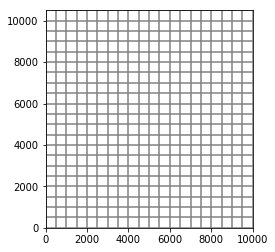

In [21]:
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid()

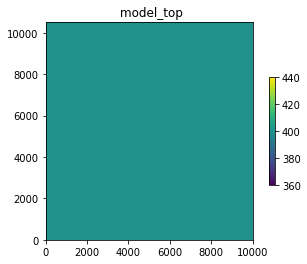

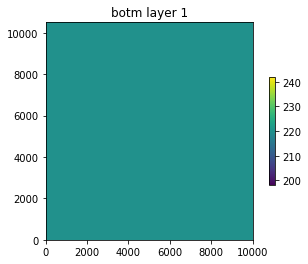

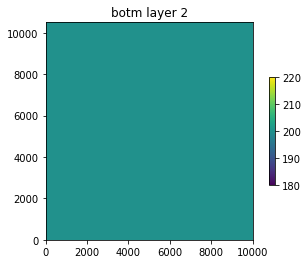

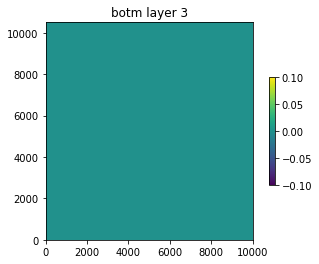

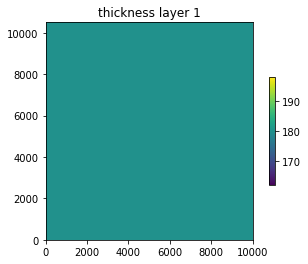

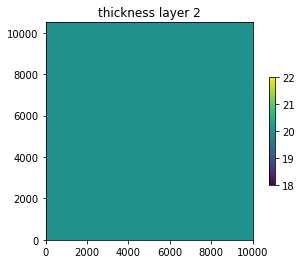

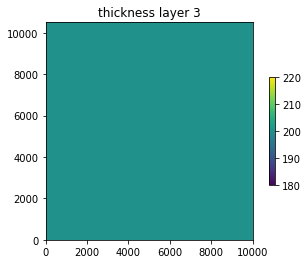

In [13]:
dis.plot()

In [9]:
bas = flopy.modflow.ModflowBas(m, strt = 320) #set initial head to 320

In [10]:
hk = [50,0.01,200] #horizontal conductivity
vk = [10, 0.01, 20] #vertical conductivity
laytyp = [1, 0, 0] #type of layer (first layer is unconfined and lower two layers are confined)

In [11]:
lpf = flopy.modflow.ModflowLpf(m, laytyp = laytyp,
                                hk = hk, vka = vk)

In [12]:
rech = 0.005 #recharge rate is 0.005 ft/day
rch = flopy.modflow.ModflowRch(m, rech = rech)

In [59]:
#dictionary can be used to define data for different stress period... first stress period is 0
#must specify layer, row, col, and pumping rate
well_data = {0:[[0,10,9, -150000]]} #The well is located in layer 3, row 11, column 10. The pumping rate is -150,000 ft3/day
wel = flopy.modflow.ModflowWel(m, stress_period_data = well_data)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...


In [78]:
# layer row col stage conductance bottom
riv_data = [(0, i, 19, 320, 1e5, 318) for i in range(10)] #The river is located in layer 1 and column 20 in every row 
#in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5.
riv = flopy.modflow.ModflowRiv(m, stress_period_data = {0: riv_data})

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfriv.ModflowRiv'> <class 'flopy.modflow.mfriv.ModflowRiv'>
replacing existing Package...


In [79]:
pcg = flopy.modflow.ModflowPcg(m, rclose=0.1) #RCLOSE—is the residual criterion for convergence ft3/day

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...


In [80]:
#Define the output control for the model and set stress_period_data to {(0, 0): ['save head', 'save budget']} 
#to save the head and flow for the model.
oc = flopy.modflow.ModflowOc(m, stress_period_data={(0, 0): ['save head', 'save budget']}) 

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


In [81]:
#save cell by cell flow data
oc.reset_budgetunit(131)

In [82]:
m.write_input()
m.run_model()

FloPy is using the following  executable to run the model: C:\Users\cnpeters\Documents\Projects\DelawareStream\FloPy\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modflowtest.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/06/10 16:45:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/06/10 16:45:01
 Elapsed run time:  0.049 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)


(False, [])

In [83]:
#Extract heads
hobj = flopy.utils.HeadFile(ws+'/modflowtest.hds')
hds = hobj.get_data()

In [75]:
#Load the cell-by-cell file
cobj = flopy.utils.CellBudgetFile(ws+'/modflowtest.cbc')
cobj.list_unique_records()

RECORD           IMETH
----------------------
CONSTANT HEAD        2
FLOW RIGHT FACE      1
FLOW FRONT FACE      1
FLOW LOWER FACE      1
WELLS                5
RIVER LEAKAGE        5
RECHARGE             3


In [76]:
#Retrieve the 'FLOW RIGHT FACE' and 'FLOW FRONT FACE' data types from the cell-by-cell file
frf = cobj.get_data(text='FLOW RIGHT FACE')[0]
fff = cobj.get_data(text='FLOW FRONT FACE')[0]

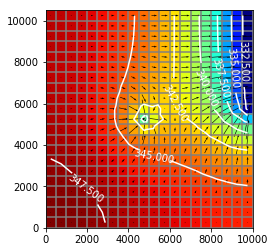

In [77]:
mv = flopy.plot.PlotMapView(model = m, layer = 1)
mv.plot_grid()
mv.plot_array(hds, cmap='jet') #plot simulated heads
c = mv.contour_array(hds, colors = 'white')
plt.clabel(c)
mv.plot_discharge(frf=frf,fff=fff)